## Bank Marketing Data EDA
The notebook is structured as follows:
1. import the data
2. EDA and summary statistics on numeric variables
3. EDA on categorical variables
4. Explore variable relationships

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os

# I usually keep functions like this in their own module
# but that seemed excessive for this use case
def iv_woe(data, target, bins=10, show_woe=False):
    """ function from: 
    https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
    """
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

plot_path = r'C:\Users\Tina\Desktop\rocket_case_study\plots'

In [2]:
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
df = X.join(y)
print(X.shape, y.shape, df.shape)

# # metadata 
# print(bank_marketing.metadata) 
  
# # variable information 
# print(bank_marketing.variables) 
display(df.head())

(45211, 16) (45211, 1) (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [3]:
display(bank_marketing.variables) 

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


In [4]:
# data dictionaries can be useful
df_dict = bank_marketing.variables
df_dict['type_binary'] = np.where(df_dict['type']=='Integer', 'N', 'C')
cat_var = df_dict[df_dict["type_binary"]=="C"]["name"].to_list()
num_var = df_dict[df_dict["type_binary"]=="N"]["name"].to_list()

In [5]:
# check the null rate
# does not match the metadata
df.isnull().sum()/len(df)

age            0.000000
job            0.006370
marital        0.000000
education      0.041074
default        0.000000
balance        0.000000
housing        0.000000
loan           0.000000
contact        0.287983
day_of_week    0.000000
month          0.000000
duration       0.000000
campaign       0.000000
pdays          0.000000
previous       0.000000
poutcome       0.817478
y              0.000000
dtype: float64

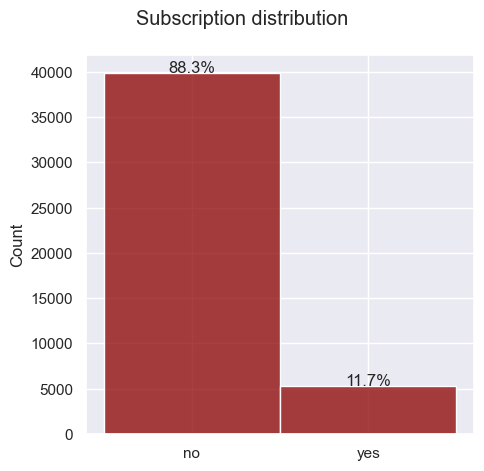

In [6]:
feature = 'y'
sns.set(style="whitegrid")  
sns.set(rc={'figure.figsize':(5, 5)})
ax = sns.histplot(data=df, x='y', kde=False, color="darkred")
plt.suptitle("Subscription distribution")
no = len(df[(df[feature] == 'no')])/len(df)*100
yes = len(df[(df[feature] == 'yes')])/len(df)*100
percentage = [no, yes]
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.tight_layout()
plt.xlabel("")
plt.savefig(os.path.join(plot_path, 'subscription.png'))
plt.show()

## Numeric variable EDA

In [7]:
df.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


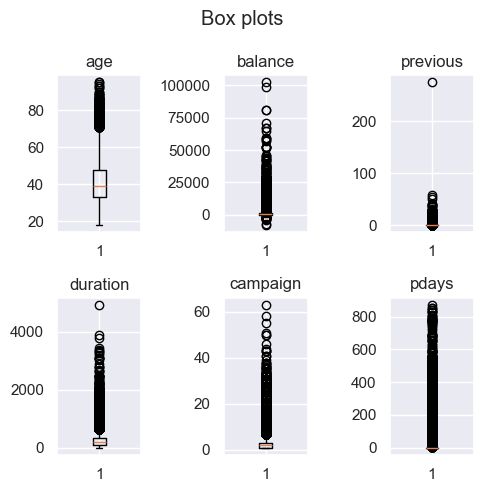

In [8]:
fig, axs = plt.subplots(2, 3)

# basic plot
axs[0, 0].boxplot(df.age)
axs[0, 0].set_title('age')

# notched plot
axs[0, 1].boxplot(df.balance)
axs[0, 1].set_title('balance')

# change outlier point symbols
axs[0, 2].boxplot(df.previous)
axs[0, 2].set_title('previous')

# don't show outlier points
axs[1, 0].boxplot(df.duration)
axs[1, 0].set_title("duration")

# horizontal boxes
axs[1, 1].boxplot(df.campaign)
axs[1, 1].set_title('campaign')

# change whisker length
axs[1, 2].boxplot(df.pdays)
axs[1, 2].set_title('pdays')
fig.subplots_adjust(left=.01, right=1, bottom=0.05, top=0.9,
                    hspace=0.5, wspace=0.5)
plt.suptitle("Box plots")
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'box_plots.png'))
plt.show()

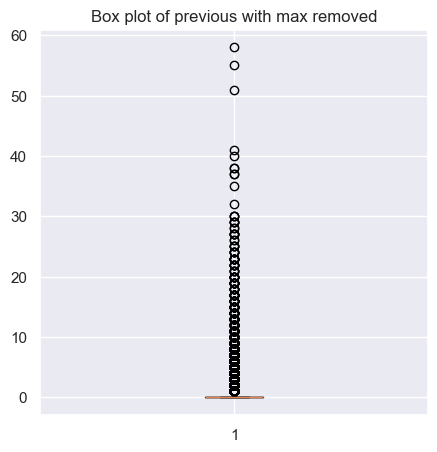

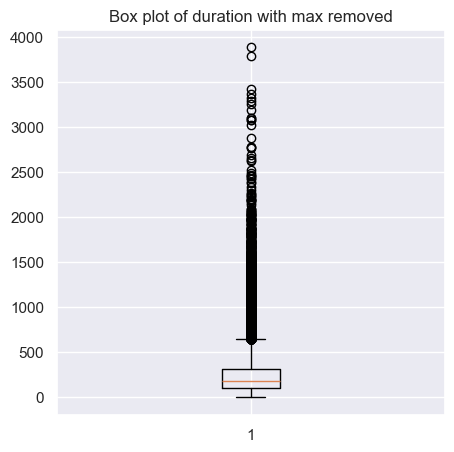

In [9]:
for feature in ['previous', 'duration']:    
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'Box plot of {feature} with max removed')
    ax1.boxplot(df[df[feature]<df[feature].max()][feature])
    plt.savefig(os.path.join(plot_path, f'box_plots_{feature}.png'))
    plt.show()

In [10]:
# remove the row with the outlier data point in the "previous" and "duration"
df = df[df.previous<df.previous.max()].copy()
df = df[df.duration<df.duration.max()].copy()

## Categorical variables

In [11]:
for column in df[cat_var].columns:
    # print(column, len(pd.unique(df[column])))
    display(df[column].value_counts(dropna=False, normalize = True))

job
blue-collar      0.215267
management       0.209184
technician       0.168020
admin.           0.114380
services         0.091884
retired          0.050079
self-employed    0.034927
entrepreneur     0.032892
unemployed       0.028822
housemaid        0.027428
student          0.020748
NaN              0.006370
Name: proportion, dtype: float64

marital
married     0.601916
single      0.282908
divorced    0.115176
Name: proportion, dtype: float64

education
secondary    0.513216
tertiary     0.294167
primary      0.151541
NaN          0.041076
Name: proportion, dtype: float64

default
no     0.981973
yes    0.018027
Name: proportion, dtype: float64

housing
yes    0.555819
no     0.444181
Name: proportion, dtype: float64

loan
no     0.839766
yes    0.160234
Name: proportion, dtype: float64

contact
cellular     0.647747
NaN          0.287996
telephone    0.064257
Name: proportion, dtype: float64

day_of_week
20    0.060873
18    0.051052
21    0.044814
17    0.042890
6     0.042735
5     0.042248
14    0.040877
8     0.040744
28    0.040479
7     0.040191
19    0.038864
29    0.038599
15    0.037669
12    0.035458
13    0.035059
30    0.034639
9     0.034529
11    0.032715
4     0.031963
16    0.031299
2     0.028578
27    0.024796
3     0.023867
26    0.022894
23    0.020770
22    0.020018
25    0.018580
31    0.014223
10    0.011568
24    0.009887
1     0.007122
Name: proportion, dtype: float64

month
may    0.304497
jul    0.152514
aug    0.138180
jun    0.118140
nov    0.087792
apr    0.064854
feb    0.058572
jan    0.031034
oct    0.016324
sep    0.012807
mar    0.010551
dec    0.004734
Name: proportion, dtype: float64

poutcome
NaN        0.817492
failure    0.108408
other      0.040678
success    0.033423
Name: proportion, dtype: float64

y
no     0.88301
yes    0.11699
Name: proportion, dtype: float64

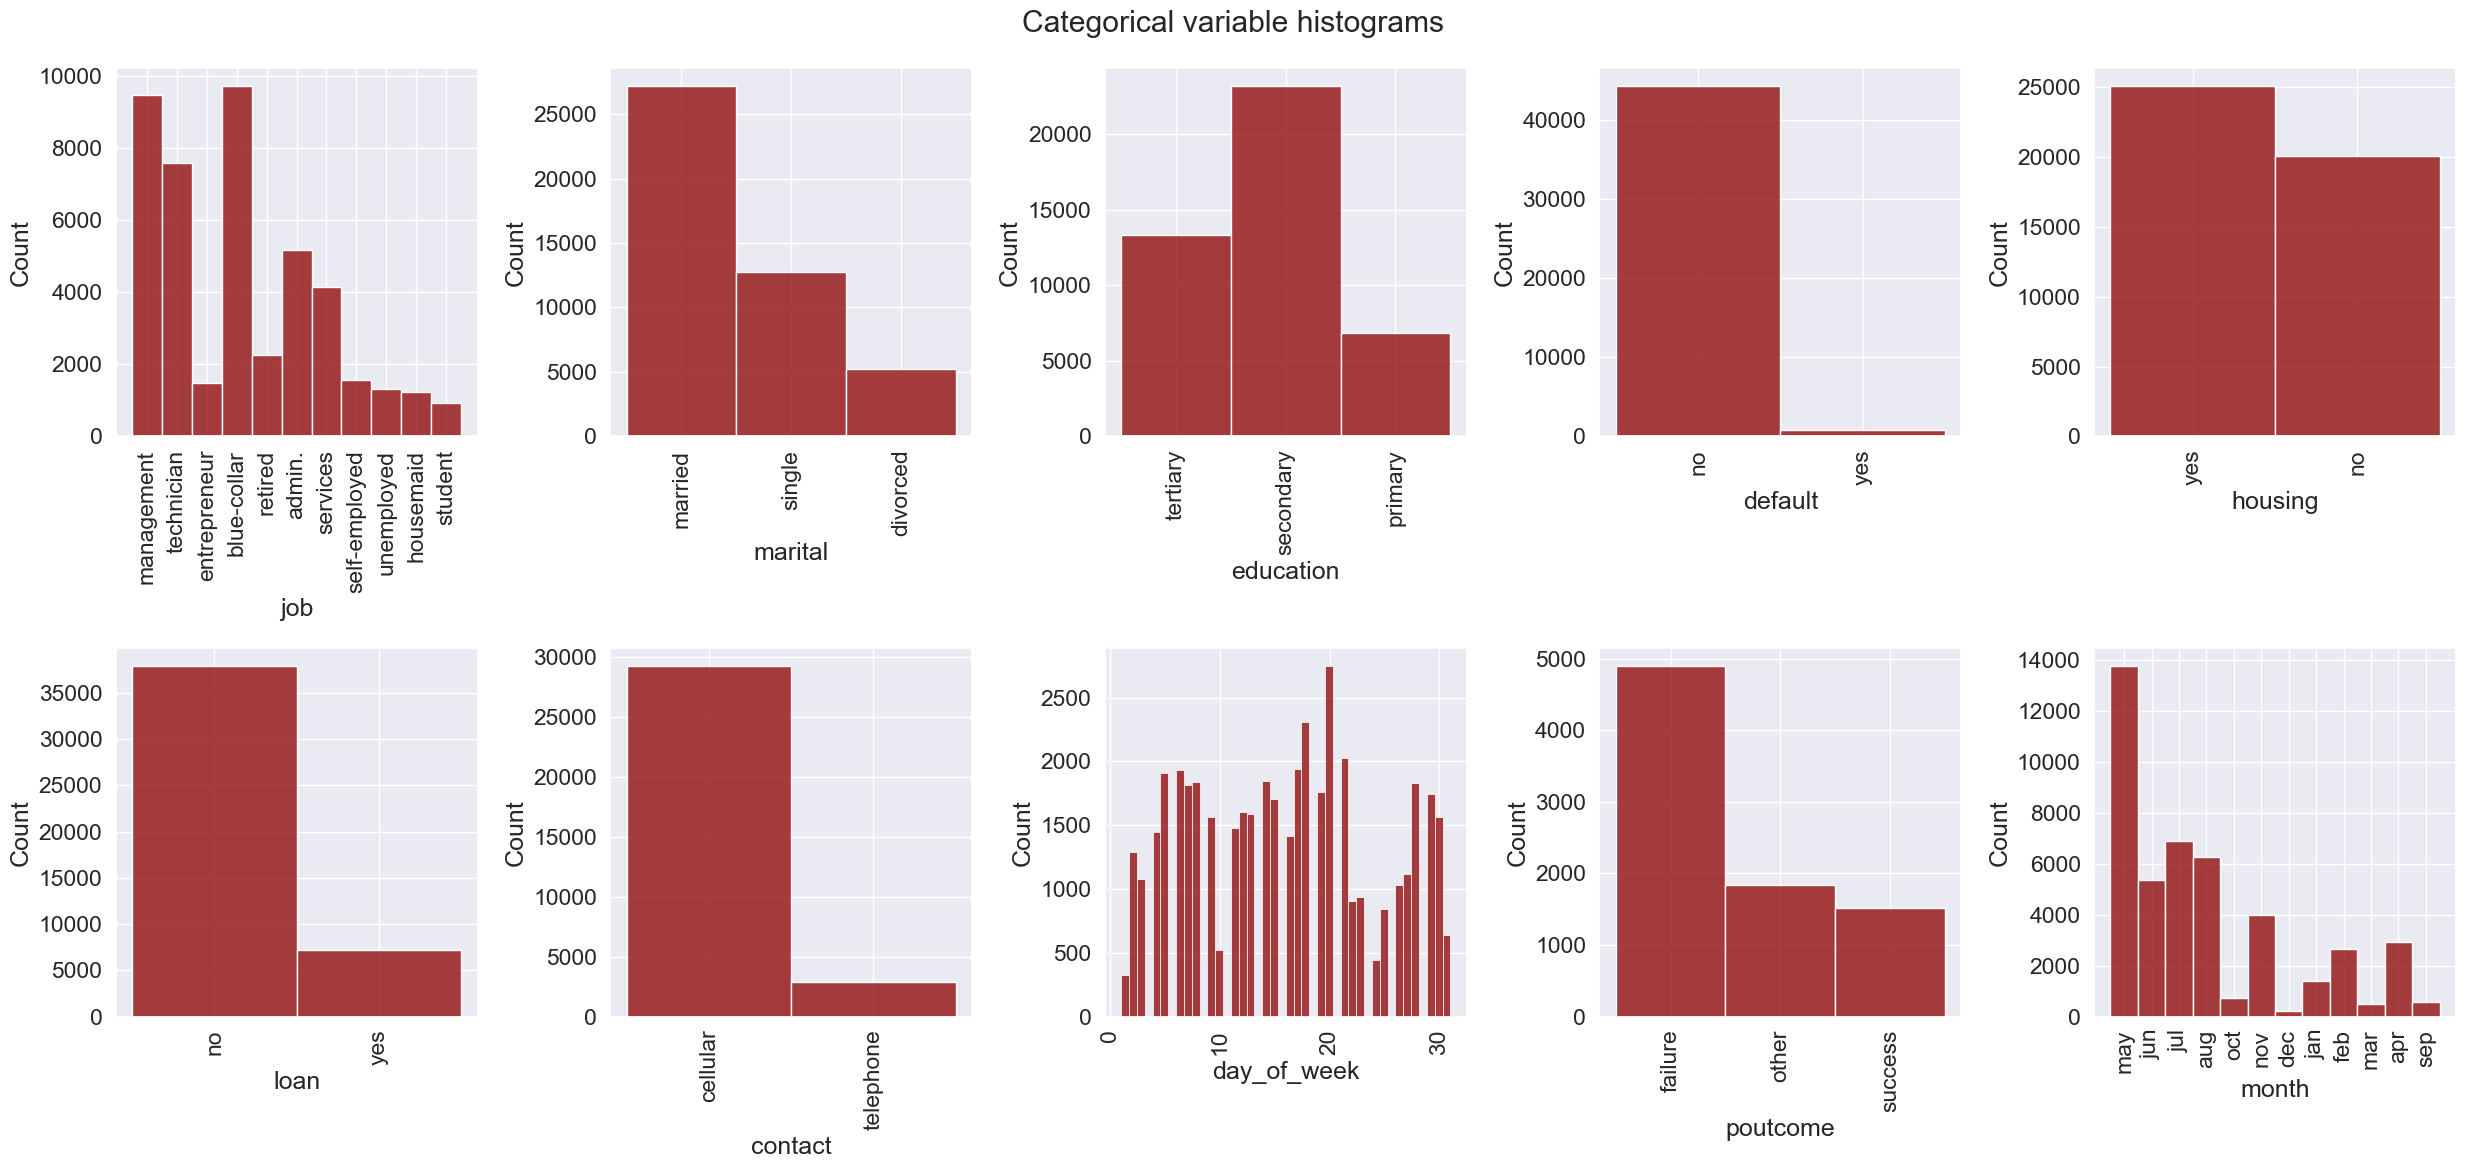

In [12]:
sns.set(style="whitegrid")
sns.set(font_scale=1.5)  
fig,axs = plt.subplots(2,5, figsize = (25, 12))
sns.histplot(data=df, x='job', kde=False, color="darkred", ax=axs[0, 0]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='marital', kde=False, color="darkred", ax=axs[0, 1]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='education', kde=False, color="darkred", ax=axs[0, 2]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='default', kde=False, color="darkred", ax=axs[0, 3]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='housing', kde=False, color="darkred", ax=axs[0, 4]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='loan', kde=False, color="darkred", ax=axs[1, 0]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='contact', kde=False, color="darkred", ax=axs[1, 1]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='day_of_week', kde=False, color="darkred", ax=axs[1, 2]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='poutcome', kde=False, color="darkred", ax=axs[1, 3]).tick_params(axis='x', rotation=90)
sns.histplot(data=df, x='month', kde=False, color="darkred", ax=axs[1, 4]).tick_params(axis='x', rotation=90)
plt.suptitle("Categorical variable histograms")
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'cat_histograms.png'))
plt.show()

## Variable relationships

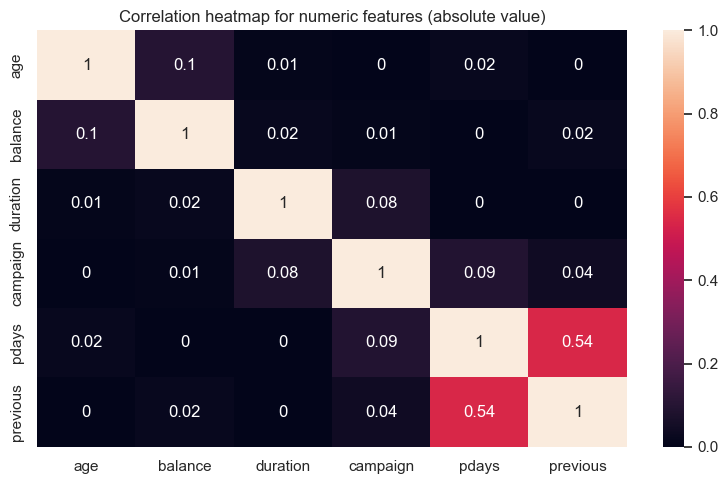

In [13]:
corr_df = df[num_var].corr()
sns.set(rc={'figure.figsize':(8, 5)})
sns.heatmap(abs(corr_df).round(2), vmin=0, vmax=1, annot=True, annot_kws={'fontsize':12})
plt.title("Correlation heatmap for numeric features (absolute value)")
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'num_corr.png'))
plt.show()

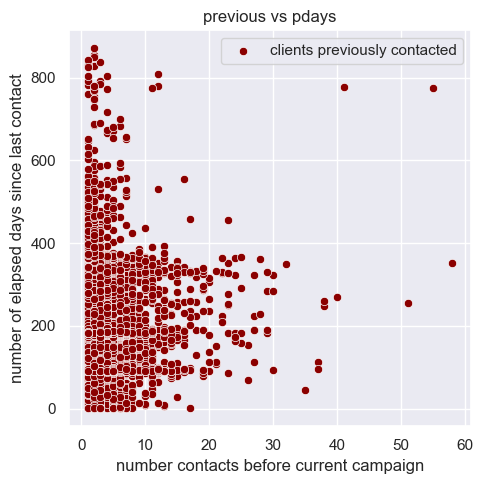

In [14]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.scatterplot(data= df[df['previous'] > 0], x = 'previous', y= 'pdays', color = 'darkred', label = 'clients previously contacted')
plt.title("previous vs pdays")
plt.ylabel('number of elapsed days since last contact')
plt.xlabel('number contacts before current campaign')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'pdays_previous.png'))
plt.show()

In [15]:
# data frame with encoded categorical variables for IV calculation
# encoding does not preserve null values which is fine for IV
encoded_df = df[cat_var].apply(LabelEncoder().fit_transform)
encoded_df = df[num_var].join(encoded_df)
print(encoded_df.shape)
display(encoded_df.head())

(45209, 17)


,age,balance,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,day_of_week,month,poutcome,y
0,58,2143,261,1,-1,0,4,1,2,0,1,0,2,4,8,3,0
1,44,29,151,1,-1,0,9,2,1,0,1,0,2,4,8,3,0
2,33,2,76,1,-1,0,2,1,1,0,1,1,2,4,8,3,0
3,47,1506,92,1,-1,0,1,1,3,0,1,0,2,4,8,3,0
4,33,1,198,1,-1,0,11,2,3,0,0,0,2,4,8,3,0


In [16]:
iv, woe = iv_woe(encoded_df, 'y', bins=10, show_woe=False)

Information value of age is 0.116045
Information value of balance is 0.101963
Information value of duration is 1.609716
Information value of campaign is 0.067622
Information value of pdays is 0.011993
Information value of previous is 0.107879
Information value of job is 0.081389
Information value of marital is 0.040112
Information value of education is 0.050144
Information value of default is 0.006257
Information value of housing is 0.188645
Information value of loan is 0.054869
Information value of contact is 0.300428
Information value of day_of_week is 0.05701
Information value of month is 0.223999
Information value of poutcome is 0.514628


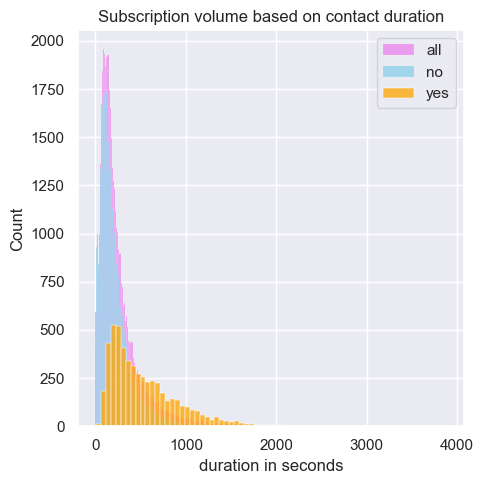

In [17]:
feature = 'duration'
sns.histplot(data=df, x=feature, kde=False, color="violet", label = "all")
sns.histplot(data=df[df.y == 'no'], x=feature, kde=False, color="skyblue", label = "no")
sns.histplot(data=df[df.y == 'yes'], x=feature, kde=False, color="orange", label = "yes")
plt.xlabel("duration in seconds")
plt.legend()
plt.title("Subscription volume based on contact duration")
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'subscription_duration.png'))
plt.show()

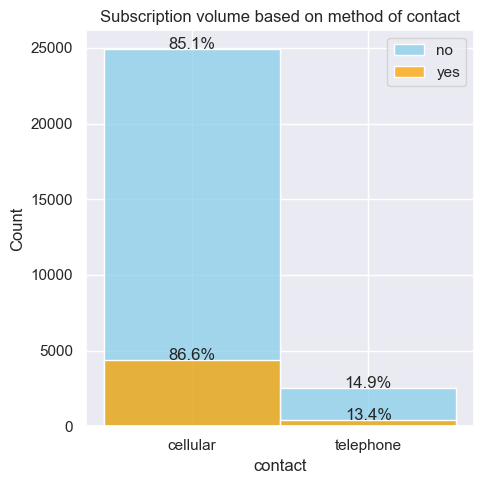

In [18]:
feature = 'contact'
# sns.histplot(data=df, x=feature, kde=False, color="violet", label = "all")
ax = sns.histplot(data=df[df.y == 'no'], x=feature, kde=False, color="skyblue", label = "no")
sns.histplot(data=df[df.y == 'yes'], x=feature, kde=False, color="orange", label = "yes")
nono = len(df[(df[feature]  == 'cellular')&(df.y == 'no')])/len(df[df[feature]  == 'cellular'])*100
noyes = len(df[(df[feature]  == 'cellular')&(df.y == 'yes')])/len(df[df[feature]  == 'cellular'])*100
yesno = len(df[(df[feature]  == 'telephone')&(df.y == 'no')])/len(df[df[feature]  == 'telephone'])*100
yesyes = len(df[(df[feature]  == 'telephone')&(df.y == 'yes')])/len(df[df[feature]  == 'telephone'])*100
percentage = [nono, noyes, yesno, yesyes]
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.legend()
plt.title('Subscription volume based on method of contact')
plt.xlabel(feature)
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'subscription_current_contact.png'))
plt.show()

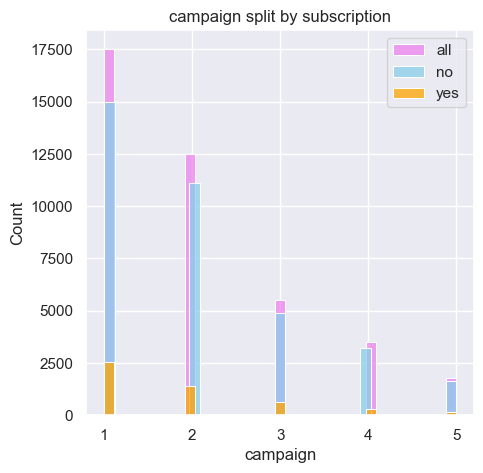

In [19]:
feature = 'campaign'
sns.histplot(data=df[(df[feature] <=5)], x=feature, kde=False, color="violet", label = "all")
sns.histplot(data=df[(df[feature] <=5)&(df['y'] =='no')], x=feature, kde=False, color="skyblue", label = "no")
sns.histplot(data=df[(df[feature] <=5)&(df['y'] =='yes')], x=feature, kde=False, color="orange", label = "yes")
plt.legend()
plt.title(f"{feature} split by subscription")
plt.savefig(os.path.join(plot_path, 'subscription_campaign.png'))
plt.show()

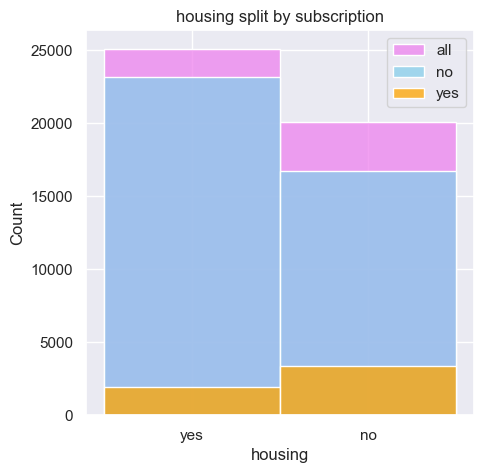

In [20]:
feature = 'housing'
sns.histplot(data=df, x=feature, kde=False, color="violet", label = "all")
sns.histplot(data=df[df.y == 'no'], x=feature, kde=False, color="skyblue", label = "no")
sns.histplot(data=df[df.y == 'yes'], x=feature, kde=False, color="orange", label = "yes")

plt.legend()
plt.title(f"{feature} split by subscription")
plt.savefig(os.path.join(plot_path, 'subscription_housing.png'))
plt.show()

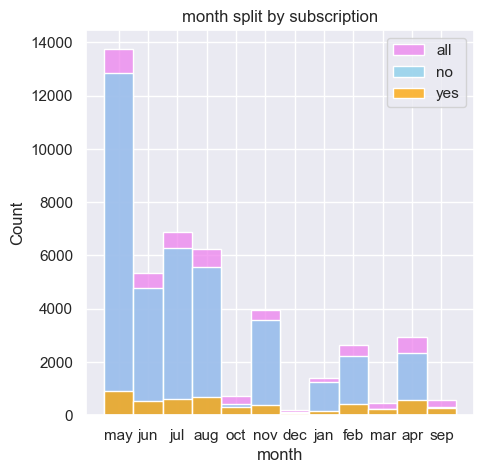

In [21]:
feature = 'month'
sns.histplot(data=df, x=feature, kde=False, color="violet", label = "all")
sns.histplot(data=df[df.y == 'no'], x=feature, kde=False, color="skyblue", label = "no")
sns.histplot(data=df[df.y == 'yes'], x=feature, kde=False, color="orange", label = "yes")
plt.legend()
plt.title(f"{feature} split by subscription")
plt.savefig(os.path.join(plot_path, 'subscription_month.png'))
plt.show()

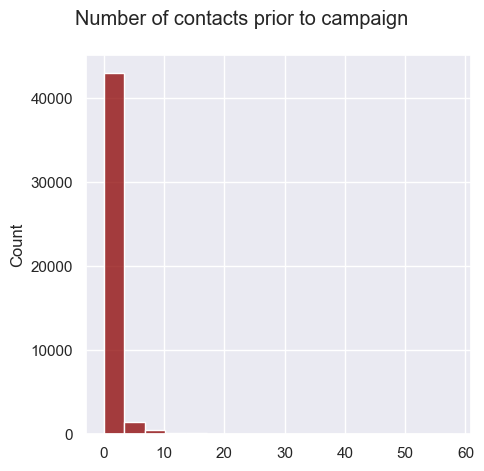

In [22]:
sns.set(style="whitegrid")  
sns.set(rc={'figure.figsize':(5, 5)})
sns.histplot(data=df, x='previous', kde=False, color="darkred")
plt.suptitle("Number of contacts prior to campaign")
plt.tight_layout()
plt.xlabel("")
plt.savefig(os.path.join(plot_path, 'previous_num.png'))
plt.show()

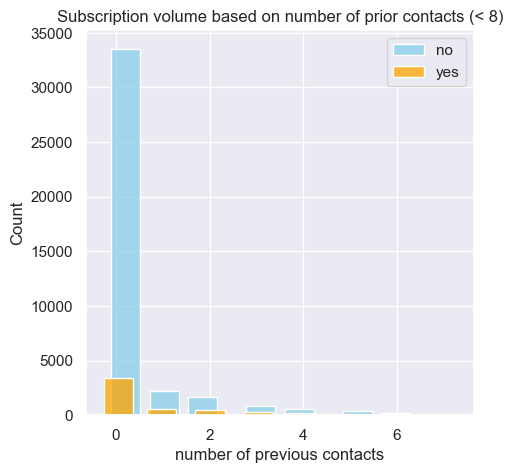

In [23]:
feature = 'previous'
# sns.histplot(data=df[(df.previous <8)], x=feature, kde=False, color="violet", label = "all")
sns.histplot(data=df[(df.y == 'no')&(df.previous <8)], x=feature, kde=False, color="skyblue", label = "no", shrink=1.5)
sns.histplot(data=df[(df.y == 'yes')&(df.previous <8)], x=feature, kde=False, color="orange", label = "yes", shrink=5.5)
plt.legend()
plt.xlabel("number of previous contacts")
plt.title("Subscription volume based on number of prior contacts (< 8)")
plt.savefig(os.path.join(plot_path, 'subscription_prev_num.png'))
plt.show()

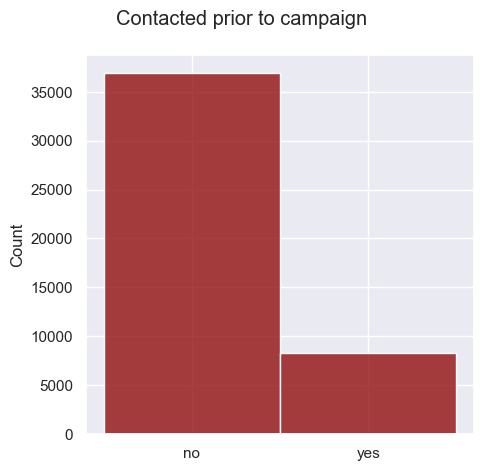

In [24]:
df['previous_binary'] = np.where(df['previous']>0, 'yes', 'no')
feature = 'previous_binary'
sns.set(style="whitegrid")  
sns.set(rc={'figure.figsize':(5, 5)})
sns.histplot(data=df, x=feature, kde=False, color="darkred")
plt.suptitle("Contacted prior to campaign")
plt.tight_layout()
plt.xlabel("")
plt.savefig(os.path.join(plot_path, 'previous_binary.png'))
plt.show()

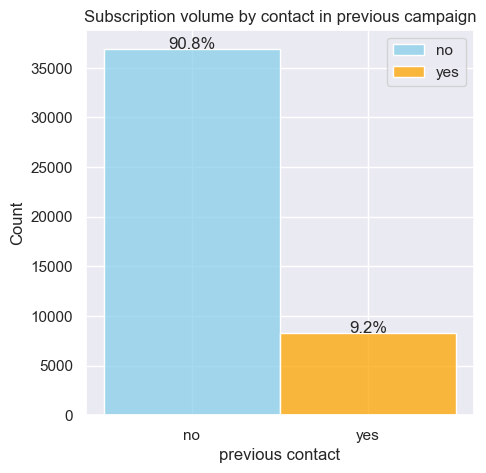

In [25]:
feature = 'previous_binary'
# sns.histplot(data=df, x=feature, kde=False, color="violet", label = "all")
ax = sns.histplot(data=df[df[feature] == 'no'], x=feature, kde=False, color="skyblue", label = "no")
sns.histplot(data=df[df[feature] == 'yes'], x=feature, kde=False, color="orange", label = "yes")
nono = len(df[(df[feature] == 'no')&(df.y == 'no')])/len(df[df[feature] == 'no'])*100
noyes = len(df[(df[feature] == 'no')&(df.y == 'yes')])/len(df[df[feature] == 'no'])*100
yesno = len(df[(df[feature] == 'yes')&(df.y == 'no')])/len(df[df[feature] == 'yes'])*100
yesyes = len(df[(df[feature] == 'yes')&(df.y == 'yes')])/len(df[df[feature] == 'yes'])*100
percentage = [nono, noyes, yesno, yesyes]
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.legend()
plt.title('Subscription volume by contact in previous campaign')
plt.xlabel("previous contact")
plt.savefig(os.path.join(plot_path, 'subscription_prev_contact.png'))
plt.show()

In [26]:
df['y_bin'] = np.where(df['y']=="yes", 1, 0)
iv, woe = iv_woe(df[['previous_binary', 'y_bin']], 'y_bin', bins=10, show_woe=False)

Information value of previous_binary is 0.21927
